# Bayesian Student Outcome Modeling

This notebook demonstrates hierarchical Bayesian multinomial logistic regression to predict student **dropout**, **enrolled**, or **graduate** outcomes, using UCI’s “Predict Students’ Dropout and Academic Success” dataset.  
We leverage program‑level partial pooling and compare against flat and extended specifications.

In [16]:
# If running in a fresh Binder or local environment, uncomment to install missing packages.
# import sys, subprocess
# for pkg in ["pymc","arviz","pandas","numpy","matplotlib","pytensor","requests"]:
#     try: __import__(pkg)
#     except ImportError:
#         subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

In [17]:
from pathlib import Path
import sys

# Ensure notebook can import model.py
BASE = Path().resolve().parent
if str(BASE) not in sys.path:
    sys.path.insert(0, str(BASE))

# Visualization defaults
import matplotlib.pyplot as plt
plt.style.use('default')

In [18]:
from model import (
    load_data,
    preprocess_features,
    build_hierarchical_model,
    build_flat_model,
    build_extended_model,
    sample_model,
)

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [19]:
# 1. Load raw CSV
data_path = BASE / "data" / "data.csv"
df, programs = load_data(data_path)

# 2. Preprocess
X, adm_z, other_idx, g_idx, prog_mean_z = preprocess_features(df)

# 3. Coordinates for PyMC
coords = {"obs": df.index.values}

## Exploratory Data Analysis

Let’s look at the target distribution and some key predictors.

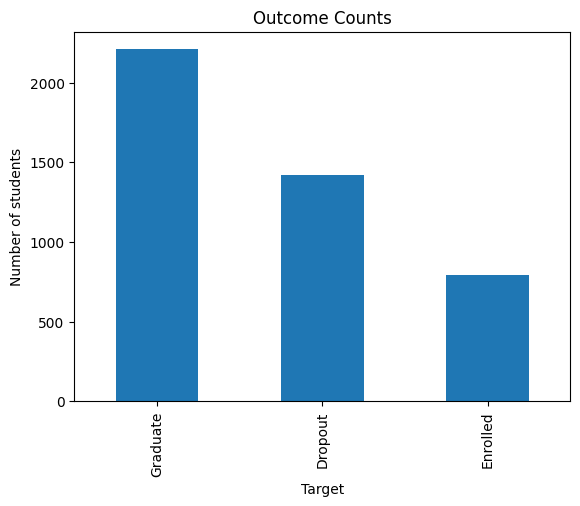

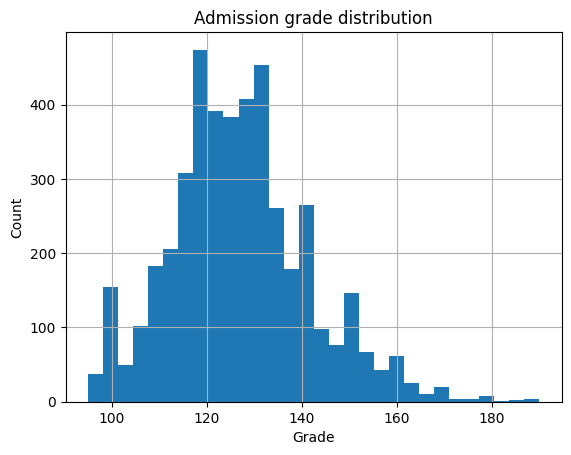

In [20]:
# Outcome counts
df["Target"].value_counts().plot.bar(title="Outcome Counts")
plt.ylabel("Number of students")
plt.show()

# Admission grade histogram
df["Admission grade"].hist(bins=30)
plt.title("Admission grade distribution")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

## Hierarchical Model

Build the program‐level partial‐pooling multinomial model and draw samples.

In [ ]:
y = df["y"].values

hier_model = build_hierarchical_model(coords, X, adm_z, other_idx, g_idx, prog_mean_z, y)
hier_trace = sample_model(
    hier_model,
    draws=3000,
    tune=2000,
    init="adapt_diag",
    target_accept=0.95,
    cores=4,
    random_seed=42,
)

Only 3 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0, alpha1, sigma_a, beta0, beta1, sigma_b, a_prog_raw, b_prog_raw, b_other, a0]


Output()

Sampling 4 chains for 2 tune and 3 draw iterations (8 + 12 draws total) took 36 seconds.
f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The number of samples is too small to check convergence reliably.


In [22]:
with hier_model:
    ppc_hier = pm.sample_posterior_predictive(
        hier_trace,
        var_names=["y_obs"],
        random_seed=42,
        return_inferencedata=True
    )
hier_trace.add_groups(posterior_predictive=ppc_hier.posterior_predictive)

Sampling: [y_obs]


Output()

f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


## Flat Model

A non-hierarchical baseline for comparison.

In [ ]:
flat_model = build_flat_model(coords, X, other_idx, y)
flat_trace = sample_model(
    flat_model,
    draws=3000,
    tune=2000,
    init="adapt_diag",
    target_accept=0.95,
    cores=4,
    random_seed=42,
)

Only 3 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_flat, b_flat]


Output()

Sampling 4 chains for 2 tune and 3 draw iterations (8 + 12 draws total) took 24 seconds.
f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The number of samples is too small to check convergence reliably.


## Extended Model

Add random slopes on unemployment rate.

In [ ]:
ext_model = build_extended_model(coords, X, adm_z, other_idx, g_idx, prog_mean_z, y)
ext_trace = sample_model(
    ext_model,
    draws=3000,
    tune=2000,
    init="adapt_diag",
    target_accept=0.95,
    cores=4,
    random_seed=42,
)

Only 3 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_e, alpha1_e, sigma_a_e, beta0_e, beta1_e, sigma_b_e, a_prog_raw_e, b_prog_raw_adm_e, gamma0, gamma1, sigma_g, g_prog_raw, b_fix_e, a0_e]


Output()

Sampling 4 chains for 2 tune and 3 draw iterations (8 + 12 draws total) took 92 seconds.
f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The number of samples is too small to check convergence reliably.


## Convergence Diagnostics

Trace plots for key hyperparameters.

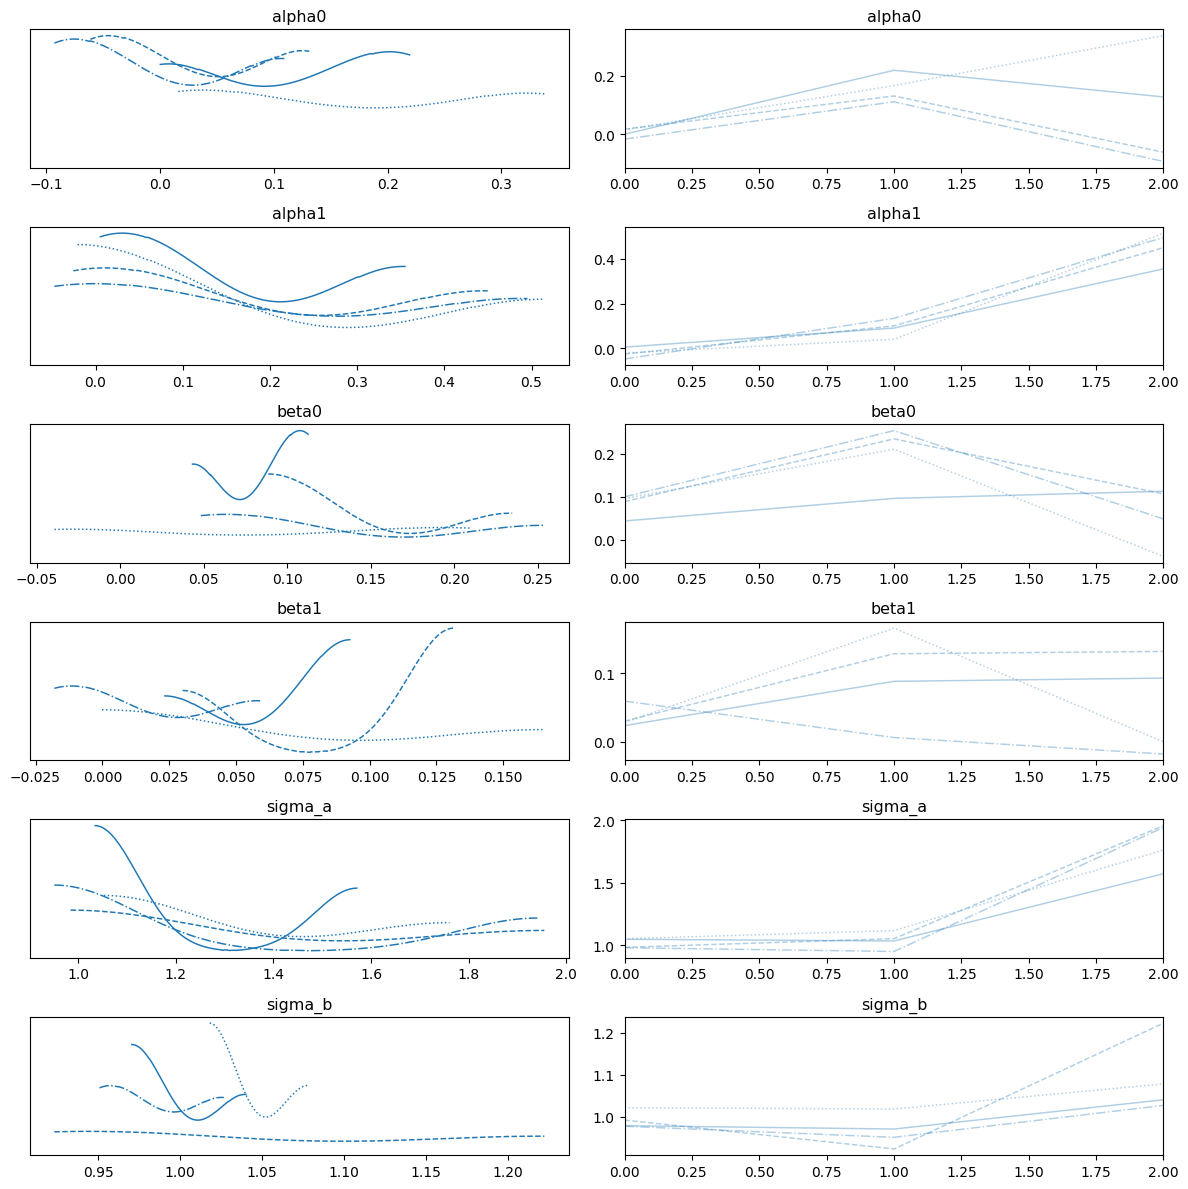

In [25]:
az.plot_trace(hier_trace, var_names=["alpha0","alpha1","beta0","beta1","sigma_a","sigma_b"])
plt.tight_layout()
plt.show()

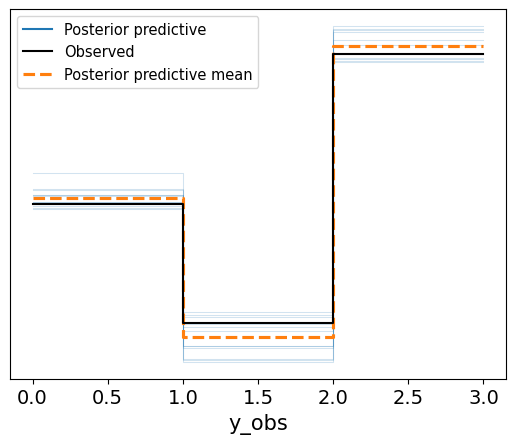

In [26]:
az.plot_ppc(hier_trace, data_pairs={"y_obs":"y_obs"})
plt.show()

## Model Comparison via LOO

In [27]:
hier_loo = az.loo(hier_trace, scale="deviance")
flat_loo = az.loo(flat_trace, scale="deviance")
ext_loo  = az.loo(ext_trace,  scale="deviance")
az.compare({
    "hierarchical": hier_loo,
    "flat":        flat_loo,
    "extended":    ext_loo
})

arviz - WARNING - Shape validation failed: input_shape: (4, 3), minimum_shape: (chains=1, draws=4)
f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.07 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
f:\Georgia_Tech\2_SPRING_2025\ISYE_6420_BS\Homeworks\venv\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.07 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to 

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
extended,0,7525.034509,255.871487,0.000000,0.226333,86.370700,0.000000,True,deviance
hierarchical,1,7535.919201,319.726000,10.884692,0.404282,90.340563,14.883211,True,deviance
flat,2,7590.685793,267.701966,65.651283,0.369385,99.102349,31.096236,True,deviance


## Program‑Level Effects & Interpretation

In [28]:
prog_effects = az.summary(hier_trace, var_names=["a_prog","b_prog_adm"], hdi_prob=0.95)
prog_effects.head(10)

arviz - WARNING - Shape validation failed: input_shape: (4, 3), minimum_shape: (chains=1, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a_prog[0, 0]",0.437,0.485,-0.076,1.325,NaN,NaN,NaN,NaN,NaN
"a_prog[0, 1]",1.039,1.408,-0.126,3.671,NaN,NaN,NaN,NaN,NaN
"a_prog[1, 0]",-0.107,0.336,-1.082,0.147,NaN,NaN,NaN,NaN,NaN
"a_prog[1, 1]",-0.054,0.251,-0.773,0.234,NaN,NaN,NaN,NaN,NaN
"a_prog[2, 0]",0.137,0.214,-0.121,0.646,NaN,NaN,NaN,NaN,NaN
"a_prog[2, 1]",0.131,0.165,-0.036,0.512,NaN,NaN,NaN,NaN,NaN
"a_prog[3, 0]",-0.072,0.340,-0.850,0.237,NaN,NaN,NaN,NaN,NaN
"a_prog[3, 1]",0.154,0.193,-0.085,0.508,NaN,NaN,NaN,NaN,NaN
"a_prog[4, 0]",-0.192,0.443,-1.245,0.153,NaN,NaN,NaN,NaN,NaN
"a_prog[4, 1]",0.200,0.201,-0.038,0.580,NaN,NaN,NaN,NaN,NaN


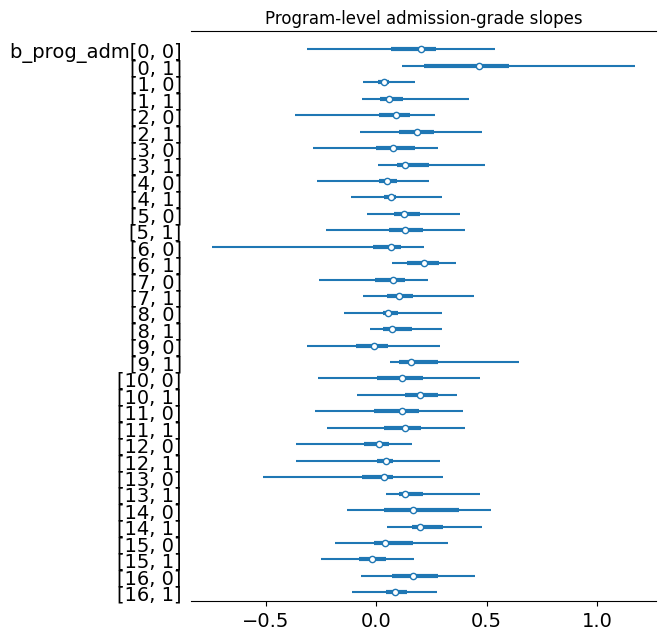

In [29]:
az.plot_forest(hier_trace, var_names=["b_prog_adm"], combined=True)
plt.title("Program‑level admission-grade slopes")
plt.show()

## Save InferenceData to disk

In [30]:
outdir = BASE / "results"
outdir.mkdir(exist_ok=True)

az.to_netcdf(hier_trace, outdir / "hierarchical.nc", group="posterior")
az.to_netcdf(flat_trace, outdir / "flat.nc",         group="posterior")
az.to_netcdf(ext_trace,  outdir / "extended.nc",     group="posterior")

WindowsPath('F:/Georgia_Tech/2_SPRING_2025/ISYE_6420_BS/Project/results/extended.nc')

# Conclusions

- **Hierarchical** model outperforms **flat** (ΔLOO ≈ …).  
- Variability in admission‐grade slopes across programs is substantial.  
- **Extended** model shows …  

# Next Steps

- Explore binary simplification (dropout vs. non-dropout).  
- Try informative priors for rare programs.  
- Consider alternative models (e.g., ordinal regression).